In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
from msresist.pre_processing import preprocessing
from msresist.figures.figure1 import plotClustergram

In [2]:
X = preprocessing(Axlmuts_ErlAF154=True, Vfilter=True, FCfilter=True, log2T=True, mc_row=True)

In [22]:
def plotClustergram(data, title=False, lim=False, robust=True, ylabel="", yticklabels=False, figsize=(10, 10)):
    """ Clustergram plot. """
    g = sns.clustermap(data, method="complete", cmap="bwr", robust=robust, vmax=lim, vmin=-lim, figsize=figsize, yticklabels=yticklabels)
    g.fig.suptitle(title, fontsize=17)
    ax = g.ax_heatmap
    ax.set_ylabel(ylabel)

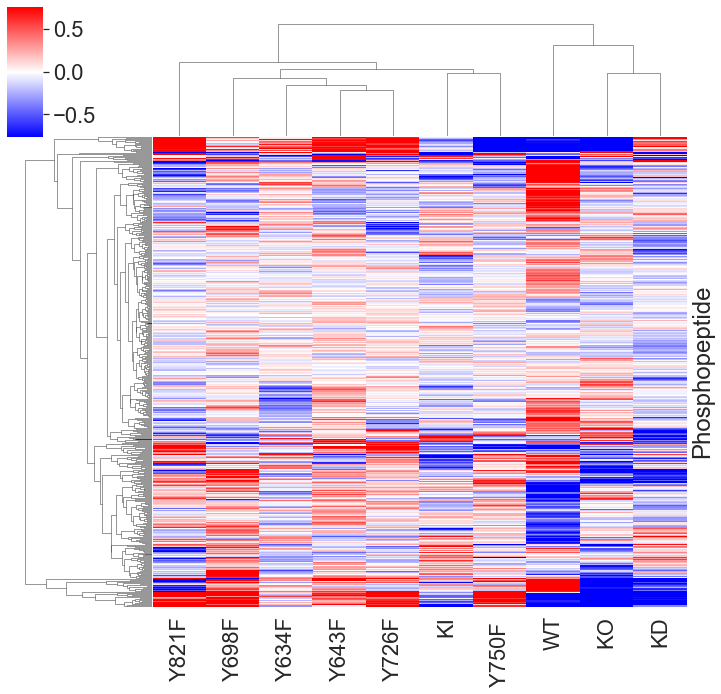

In [24]:
sns.set(style="whitegrid", font_scale=2, color_codes=True, palette="colorblind", rc={"grid.linestyle": "dotted", "axes.linewidth": 0.6})

data = X.select_dtypes(include=float)
data.columns = ["WT", "KO", "KD", "KI", "Y634F", "Y643F", "Y698F", "Y726F", "Y750F ", "Y821F"] 
plotClustergram(data, ylabel="Phosphopeptide", title="", lim=np.max(abs(data.values))*0.25)